# Sigsen: Bayesian modelling of signal source locations

Sigsen is a python package that demonstrates how Bayesian methods can be used to model and located the source of various types of signals.

## Introduction

We consider the situation of signals being emitted from multiple sources at unknown locations and detected by a set of sensors at known locations. The problem is to locate the sources.

We will restrict our selves to stationary sources that emit pulse-like signals travelling at a fixed (and known) speed, radially in all directions from the source.

### A single source

In this case the problem is simplified significantly. Indeed as long as we have three or more sensors we will be able to triangulate the position of the signal source.

### Multiple sources

The problem becomes significantly more complicated when more than one signal source is involved. In this case we have the problem of *signal attribution*, that is, given say three signal sources, a particular sensor will see three signal pulses. If we wish to triangulate we will need to be able to match up signals between sensors.

More explicitly consider sensors $A$ and $B$. They receive three signal pulses each: $a1, a2, a3$ and $b1, b2, b3$. If we wish to triangulate the source of signal pulse $a1$, should we use $b1$, $b2$ or $b3$? A priori, we have no way of knowing.

In the literature there are a number of solutions to this signal attribution problem. Part of the point of sigsen is to show that we can completely avoid the problem, and determine the likely location of the sources without solving the signal attribution problem first.

### Simplifying assumptions

We make several simplifying assumptions and provide some comments about what these mean in practice

1. **Each signal is a single pulse radiating in all directions at fixed speed.** Similar techniques could be applied to continuous signals if more information is available.
2. **The sensors record the time of arrival, and no other information.** Using other factors such as amplitude/power, frequency, phase etc would give more information one could use to locate the wave.
3. **We only consider two spatial dimensions.** This is a small assumption. Adding one more spatial dimention increases the number of sensors needed for effective location, but the techniques remain the same. This is similar to triangulating in two dimensions using the intersection of circles, and in three dimensions using spheres.
4. **All signals originate from their source simultaneously at time zero.** At first this seems like a very significant simplification, however we can simply add time as another spatial dimension. The techniques work almost the same with the difference being that the signals/sources lie on cones rather than circles (or spheres).
5. **We do not consider the problem of missing signals or data.** This could be modelled probablistically without too much extra effort.
6. **We assume we know the number of sources.** This is not a big assumption in many applications. If we are not worried about signal loss, we can just count the number of signals arriving at any sensor. There would also be other situation dependent methods to count the number of sources.

## Constructing a model

We would like to model the location of the sources probabilistically. That is, we would like come up with a probability density function that tells us the probability that a source is located at some point $(x,y)$ on the plane, given that we observe a set of data $D$ on our sensors:

$$p\left(\text{source at } (x,y) \mid D \right).$$

Bayes' theorem tells us we can calculate this as

$$p\left(\text{source at } (x,y) \mid D \right) = \frac{p\left( D \mid \text{source at } (x,y) \right) p\left(\text{source at } (x,y)\right)}{p(D)}$$

To simplify things we'll write $p(x,y)=p\left(\text{source at } (x,y)\right)$.

The quantity that we actually want to calculate $p(x,y\mid D)$ is called the **posterior distribution**.

### Breaking this down

There are three components to the above formula:

1. The factor $p(D|x,y)$ asks, what is the probability we would see the data $D$, if we knew there was a sensor at location $(x,y)$. This is called the **likelihood**.
2. The factor $p(x,y)$ is our belief about what the probability is of a source existing at location $(x,y)$ before we saw any data. E.g. we might have zero knowledge about the location and assign uniform probability over our area of interest. This is called the **prior**.
3. The denominator $p(D)$ we can treat as a normalising factor, and we won't worry about it.

A word of warning: we shouldn't be too dismissive about point 3. In actuality this gets calculated as $$p(D) = \int p(D \mid x,y) p(x,y) d\mu$$ which is where most of the computation complexity in these kinds of models lies!

### The data

We will denote an individual data point as a pair $(t, S)$ where $t$ is the time of arrival of a signal at a sensor $S$.

We make an assumption that each signal received (i.e. each piece of data) is independent of any other piece of data. That is, if $D$ is the sequence of signals $(t_1, S_{i_1}), (t_2, S_{i_2}), \ldots, (t_N, S_{i_N})$ then the probability of receiving the entire set of data is simply the product of the probabilities of receiving each one individually. That is:

$$p(D\mid x,y) = \prod_{k=1}^N p(t_k, S_{i_k} \mid x,y)$$

### The likelihood

The above means we have effectively achieved something amazing. We can answer the questions
> what is the probability of a source being at a given location given we received a particular (set of) signal(s)

by calculating
> the probability that a certain signal is received given a source at particular location.

This is where we actually need to do the modelling work, and then Bayes' rule will do the rest for us automatically. So let's get to doing this. We have the following situation:

1. A signal is emitted from a source at location $(x,y)$ travelling at speed $s$ in all directions.
2. A sensor $S$ at position $(u,v)$ will pick up the signal at $t=d/s$ where $d$ is the distance between the source and sensor.
3. However sensors are not perfect and there will be some error in the measurement. We will assume the error is normally distributed around zero, with standard deviation $\sigma$ which we will call the **noise**. This means the time $t$ recorded by the sensor as the signal's arrival time is a random variable distributed as $\mathcal{N}(d/s, \sigma)$ where $d = \sqrt{(x-u)^2+(y-v)^2}$.

Recall that the Normal distribution $\mathcal{N}(\mu, \sigma)$ is given by $f(t) = \frac{1}{\sigma\sqrt{2\pi}}\mathrm{exp}\left[-\frac{1}{2\sigma^2}(t-\mu)^2\right]$. Putting this together means we have calculated

$$p(t, S\mid x,y) = \frac{1}{\sigma\sqrt{2\pi}}\mathrm{exp}\left[-\frac{1}{2\sigma^2}(t-\frac{1}{s}\sqrt{(x-u)^2+(y-v)^2})^2\right].$$

### Log likelihood

We then need to multiply many of these likelihoods together. There is a big problem with this: numerical stability. Many of these numbers will be vanishingly small. This causes our calculations to quickly collapse to zero when dealing with floating point arithmetic. The solution is to take the log. This has the bonus of getting rid of exponentials. Denote $l(t,S\mid x,y) = \log p(t,s\mid x,y)$.

Then
$$
\begin{align}
l(D, x,y) &= \sum_{k=1}^N l(t_k, S_{i_k} \mid x,y) \\
&= \sum_{k=1}^N -\frac{1}{2\sigma^2}(t-\frac{1}{s}\sqrt{(x-u_{i_k})^2+(y-v_{i_k})^2})^2 + \log\left(\frac{1}{\sigma\sqrt{2\pi}}\right)
\end{align}
$$

Since the final term is constant, and we only care about the result up to overall proportionality, we can omit it, further simplifying calculations.

### The prior

There are many priors we can take, however the easiest is to simply six a domain in the plane in which we know our sources live and declare that the sources are uniformally likely to be anywhere in that domain. This means we can omit the prior as well from our calculations since it is constant.

## A better likelihood

The likelihood model chosen above has a problem. It is easy to understand, but we have swept under the carpet that it really only imagines there being a single source. Conflicting information (e.g. signals from two different sources arriving at the same sensor) multiplies together to give something effectively zero. This causes the model above to perform poorly.

Instead we modify our assumption that the data points are completely independent.

Suppose there are $M$ sources. If a sensor $S$ records signals at times $t_1, t_2, \ldots, t_M$, we consider this as a single data point and declare the likelihood of receiving this data to be the average of the likelihoods of receiving these signals independently:
$$ p(t_1, \ldots, t_M, S \mid x,y) = \frac{1}{M} \sum_{k=1}^M p(t_k S \mid x,y)$$
and the full likelihood would be the product over the various sensors.

This is still somewhat ad hoc, and there are much better ways to rigorously model the presense of multiple sources which would also help model missing signals etc.

## How to use the package

Now we explain how to actually use the package. There are three modules:

1. `simulator` which allows us to set up an environment for creating synthetic data.
2. `analysis` which provides the actual analytical part of the code for calulating the posterior distribution.
3. `maxima` which provides certain helper functions.

First we make some necessary imports.

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sigsen.simulator import SensorField
%matplotlib inline

From the `simulator` module we can use the class `SensorField` to fix a rectangular portion of the $xy$-plane in which out sources and sensors will live. We could think of this as the "range" where the action is happening.

The class takes four basic inputs which specify the minimum $x$ value, maximum $x$ value, minimum $y$ value and maximum $y$ value defining the rectangular region.

We can pass a pair of integers to the `add_sensor_grid` to create a grid of sensors on our range. There are other methods to add sensors in random locations or in specified locations.

Finalled we use the `display` method to create a picture of our range

(<Figure size 800x550 with 1 Axes>, <Axes: >)

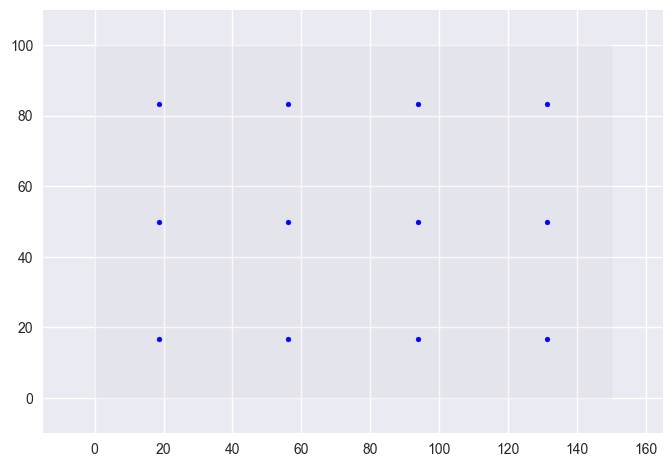

In [16]:
arange = SensorField(0,150,0,100)
arange.add_sensor_grid((3,4))
arange.display()

Now we can generate data from a event by using the `gen_data` method. This takes two parameters, the number of sources used to generate the signals, and the noise the sensors experience.

The result is a `SensorData` object. This has a `compute_distribution` to compute the posterior distribution. To this we need to pass a pair of integers which divide our range into a grid on which the calculation is made. The higher the numbers, the more computationally intesive the process.

Finally we can use the `display` method to generate a picture of the posterior distribution. The true locations of the sources are indicated with green stars.

Note: the `display` method contains a parameter `exp_factor` which defaults to `1e-4`. This is basically used to get nice pictires. If you can't see enough heatmap, make this parameter smaller. If you see too much heatmap, make this parameter lager. It doesn't change any of the calculations, just the display.

(<Figure size 800x550 with 1 Axes>, <Axes: >)

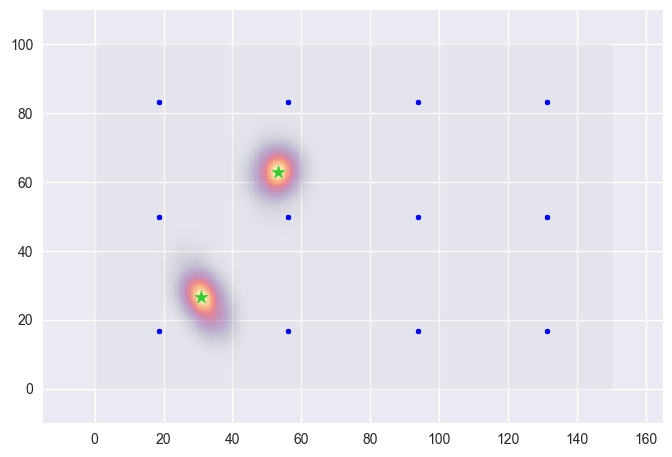

In [17]:
sigs = arange.gen_data(2, noise=0.1)
sigs.compute_distribution((200,200))
sigs.display(exp_factor=1e-4)

(<Figure size 800x550 with 1 Axes>, <Axes: >)

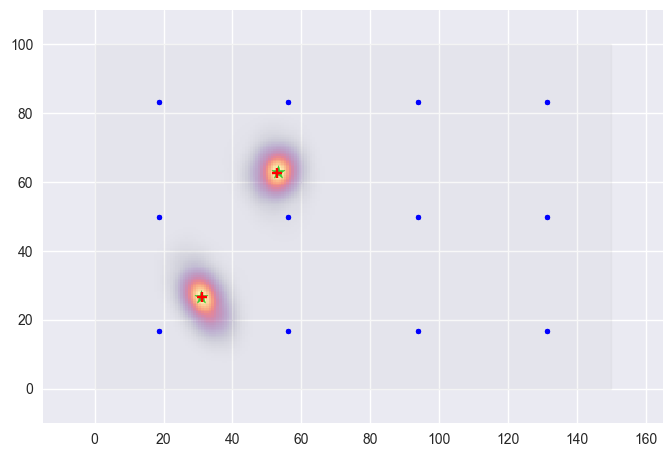

In [18]:
sigs.display(exp_factor=1e-4, show_maxima=True)

The `score` method produces the average error distance between the actual location of the source and the most likely predicted location of the source.

It should be noted that the error scales with the noise and not the size of the bounding box! See below for evidence that this is really the case.  In reality the noise would be much, much smaller and therefore so would the error.

In [19]:
sigs.score()

0.06836306311014566

Rerunning the above cells shows that the model works quite well for locating two simultaneous sources. It does start to run into trouble when the sources get close together as can be seen from the next cell. The problem being that the model only predicts a single source. (Note I've turned up the noise here so it's easier to see).

There are several factors that mean I don't think this is difficult to overcome:

1. There is potentially other information we can use to distinguish there "double sources". E.g. the power of the signals.
2. "Close together" means on the scale of the noise, which would have to be very small, even for moderately accurate sensors.
3. The algorithm I am using to find there maxima is very rudimentary and there exist many more sophisticated options.

(<Figure size 800x550 with 1 Axes>, <Axes: >)

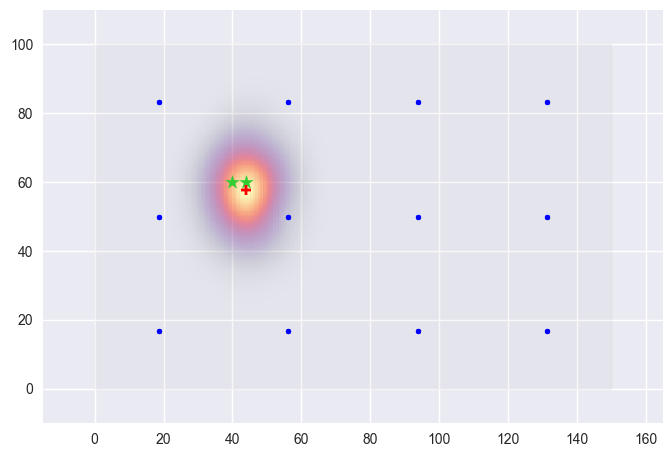

In [39]:
sigs = arange.gen_data(
    num_sources=2,
    source_locs=np.array([[40, 60], [44, 60]]),
    noise=4
)
sigs.compute_distribution(resolution=(200, 200))
sigs.display(exp_factor=0.05, show_maxima=True)

We can also experiment with significantly more sources. As you can see from the following code, the model works very well even with a large number of simultaneous sources.

(<Figure size 800x550 with 1 Axes>, <Axes: >)

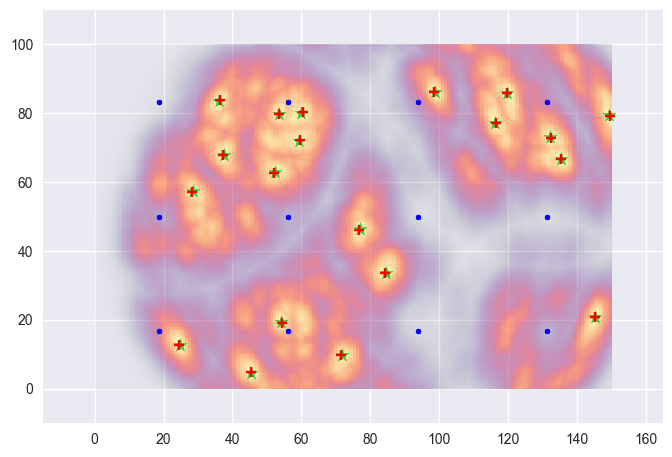

In [42]:
sigs = arange.gen_data(
    num_sources=20,
)
sigs.compute_distribution(resolution=(200, 200))
sigs.display(show_maxima=True)

To convince ourselves that the average error scales with the noise (and not the bounding box), I have included a data file `dat3x3.py` which contains 10,000 data pairs of `(noise_value, error)` where a noise value has been samples uniformly on $[0,5]$ and then used to generate data for a $3\times 3$ grid of sensors, which is then analyses and an error calculated.

We can plot the logarithm of these errors against the noise which shows a clear, almost linear relationship.

Text(0.5, 1.0, 'noise vs log error')

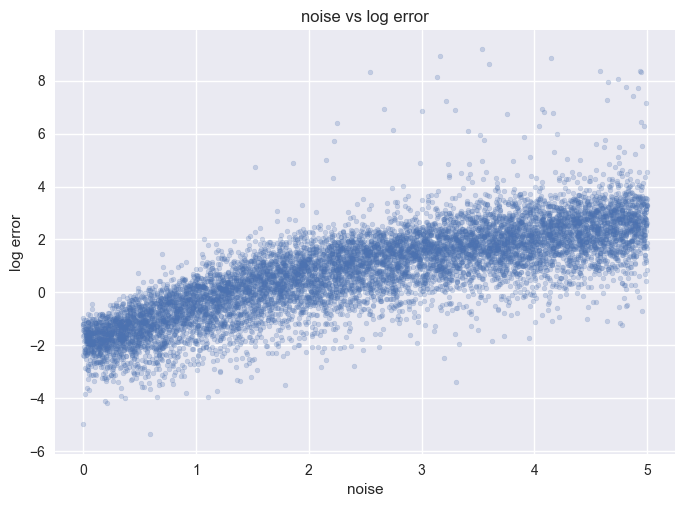

In [20]:
dat = np.load('dat3x3.npy')

fig, ax = plt.subplots()
noise = dat[:, 0]
log_error = np.log(dat[:, 1])

ax.scatter(noise, log_error, alpha=0.25, marker='.')
ax.set_xlabel('noise')
ax.set_ylabel('log error')
ax.set_title('noise vs log error')